In [2]:
import pandas as pd
import numpy as np

In [3]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#import scikit learn stuffs
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
#load the dataset
housing_data = pd.read_csv("../data/AmesHousing.csv")
housing_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [9]:
#check for null columns
print(housing_data.isna().sum().sort_values(ascending=True))

Order                0
Sale Condition       0
Heating QC           0
Central Air          0
1st Flr SF           0
                  ... 
Mas Vnr Type      1775
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
Length: 82, dtype: int64


In [12]:
#drop the column having null values more than 80 percent
threshold = 0.8

housing_data = housing_data.loc[:, housing_data.isna().mean() < threshold]
list(housing_data.columns)

['Order',
 'PID',
 'MS SubClass',
 'MS Zoning',
 'Lot Frontage',
 'Lot Area',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Kitchen Qual',
 'TotRms AbvGrd',
 'Functional',
 'Fireplaces',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'G

In [13]:
#drop the columns which does not add much to the analysis
housing_data.drop(["Order", "PID"], axis=1, inplace=True, errors="ignore")

In [14]:
#train test split data
X = housing_data.drop("SalePrice", axis=1)
y = housing_data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)


In [22]:
#select numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print(f"Numeric Features: {len(numeric_features)}")
print(f"Categorical Features: {len(categorical_features)}")

Numeric Features: 36
Categorical Features: 39


In [24]:
#define steps for numeric and categorical features pipeline
numeric_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]

categorical_steps = [
    ('imputer', SimpleImputer(strategy="most_frequent")), #mode is used for cateogrical data
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
]


In [26]:
#define the pipelines yayyy
numeric_transformer = Pipeline(numeric_steps)
categorical_transformer = Pipeline(categorical_steps)


In [ ]:
#Column Transformer stuffs
#Column transformer allows diffrent transformer to apply for different kind of features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [29]:
#Listing the models to compare
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge' : Ridge()
}

In [ ]:
#performing GridSearchCv and Cross Validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=21)

#define parameters for GridSearchCV
param_grid = {
    'Ridge': {'model__alpha': [0.1, 1, 10, 100]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1, 1]}
}

#define a dictionary to store the models
best_models = {}

for name, model in models.items():
    print(f"Training {name}")
    
    #define pipeline to be used for GridSearchCV estimator
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid = GridSearchCV(pipeline,
                        param_grid.get(name, {}),
                        cv=kf,
                        scoring='r2', #r squared
                        n_jobs=-1) #faster GridSearch
    
    grid.fit(X_train, y_train)
    best_models[name] = grid #stores the grid object for each model

print("Training Complete!")

Training LinearRegression
Training Lasso


/Users/aakashshrestha/Documents/Machine Learning/Projects/HousingPricePrediction/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383702204242.03815, tolerance: 1238845978.9755378
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/aakashshrestha/Documents/Machine Learning/Projects/HousingPricePrediction/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376302666786.83795, tolerance: 1222413468.8986657
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/aakashshrestha/Documents/Machine Learning/Projects/HousingPricePrediction/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the n

Training Ridge
Training Complete!


In [33]:
#evaluate the performance of each model

results = {}

for name, grid in best_models.items():
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Best Params': grid.best_params_,
        'Test MSE': mse, #lower better
        'Test R2': r2, #higher better
        'CV Score': grid.best_score_ #higher better
    }
    
    results_df = pd.DataFrame(results).T # T transposes the dataframe
    results_df.sort_values(by=['Test R2', 'CV Score', 'Test MSE'], ascending=[False, False, True])
    

In [34]:
#print results df
print(results_df)

                           Best Params          Test MSE   Test R2  CV Score
LinearRegression                    {}  729858849.342534  0.883497  0.802348
Lasso              {'model__alpha': 1}  697758781.595297   0.88862  0.809896
Ridge             {'model__alpha': 10}  555221991.462982  0.911373  0.831085


*Since, Ridge has the lowest MSE, Highest R2 and highest CV score, it is the best !!*

In [35]:
#store the best model 
import joblib
joblib.dump(best_models['Ridge'], '../models/ridge_best.pkl')

['../models/ridge_best.pkl']

[]

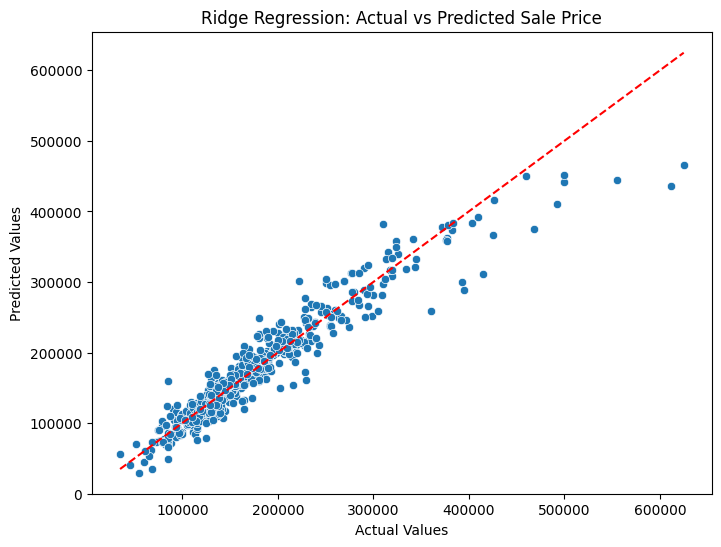

In [ ]:
#plot the graph for acutal vs predicted values
y_pred = best_models['Ridge'].predict(X_test)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Actual vs Predicted Sale Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r') #draws diagonal line
plt.plot()